# SISSA - Language Reading and The Brain - a.y. 2023-24
# Sebastiano Quintavalle - Assignment 1

## 1. Introduction


The aim of this notebook is to examine the outcomes of an experiment conducted during an academic lecture, utilizing data collected in the file `sound_symbolism.csv`. 

Within the class 22 students participated in the experiment. They were tasked with listening to 32 words in an unfamiliar language. These words described objects of either small or large size, and for each word, the students were required to choose between the two options.

### Data Preparation

Download  the file and save it locally in a directory.

(To automatically download the file from the URL, it's necessary to have previously login in Basecamp in the web browser and potentially update the URL in the `settings.py` file).

In [1]:
from settings import DATA_URL, DATA_DIR, FILE_NAME
from io_ import DataDownloader

downloader = DataDownloader(url=DATA_URL, dir_path=DATA_DIR, file_name=FILE_NAME)

downloader

DataDownloader[file: C:\Users\user.LAPTOP-G27BJ7JO\Documents\GitHub\LRB_project\assignment1\data\sound_symbolism.csv; downloaded: True]

In [2]:
downloader.download()

Directory already exists: C:\Users\user.LAPTOP-G27BJ7JO\Documents\GitHub\LRB_project\assignment1\data
File downloaded at: C:\Users\user.LAPTOP-G27BJ7JO\Documents\GitHub\LRB_project\assignment1\data\sound_symbolism.csv


After downloading the file, we proceed to load it into a dataframe.

In [3]:
from io_ import CSVLoader

loader = CSVLoader(file_path=downloader.file_path)
loader

CSVLoader[file: C:\Users\user.LAPTOP-G27BJ7JO\Documents\GitHub\LRB_project\assignment1\data\sound_symbolism.csv]

In [4]:
data = loader.load()

Loading C:\Users\user.LAPTOP-G27BJ7JO\Documents\GitHub\LRB_project\assignment1\data\sound_symbolism.csv ...
Complete


Let's inspect the first few rows.

In [5]:
data.head(10)

,word_id,sbj_id,response,word,language,meaning,is_sound_symbolic
0,word1,sbj1,big,dev,turkish,big,no
1,word1,sbj2,small,dev,turkish,big,no
2,word1,sbj3,big,dev,turkish,big,no
3,word1,sbj4,small,dev,turkish,big,no
4,word1,sbj5,small,dev,turkish,big,no
5,word1,sbj6,small,dev,turkish,big,no
6,word1,sbj7,small,dev,turkish,big,no
7,word1,sbj8,small,dev,turkish,big,no
8,word1,sbj9,big,dev,turkish,big,no
9,word1,sbj10,big,dev,turkish,big,no


There a total of 32 words and 22 subjects.

In [6]:
print(f"Tot words: {data.loc[:, 'word_id'].nunique()}")
print(f"Tot subjects: {data.loc[:, 'sbj_id'].nunique()}")

Tot words: 32
Tot subjects: 22


## 2. Analysis

### Disclaimer

To streamline the analysis flow within the notebook, the data was transformed from a tabular format. Subsequently, a class architecture was devised and documented in `model.py`. This approach enhances data modeling clarity and enables analysis to focus solely on the results, abstracting away implementation.

### Experiment words

First we establish the collection of words utilized in the experiment.

In [7]:
from model import Meaning, Word, Words

words_experiment = Words()
    
for row in data.loc[:, ['word_id', 'word', 'language', 'meaning', 'is_sound_symbolic']].drop_duplicates().itertuples(index=False):
    
    meaning = Meaning.from_string(row.meaning)
    is_sound_symbolic = row.is_sound_symbolic == "yes"
    
    new_word = Word(
        id_=row.word_id,
        word=row.word,
        language=row.language, 
        meaning=meaning,
        is_sound_symbolic=is_sound_symbolic
    )

    words_experiment.add_word(word=new_word)

The words are evenly distributed between "big" and "small". This ensures that the results are not biased and establishes a baseline of 50% score, which represents chance level.

In [8]:
words_experiment

Words[count: 32, small: 16, big: 16]

Two simple statistics that can be identified for a set of words are the average length and vowel distribution.

The distribution of vowels in the word of set evidence a majoirity of A a I (roundly 30%) and a smaller portion for letters O and U (roundly 10%).

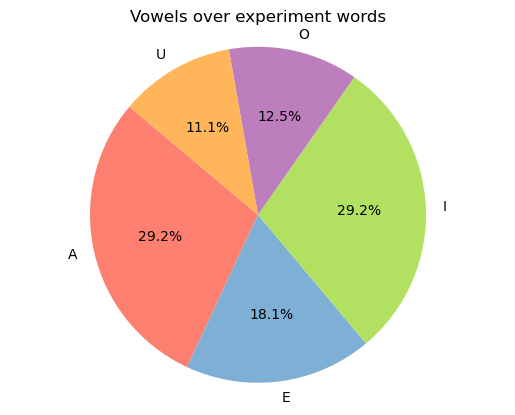

In [9]:
words_experiment.plot_vowels_distr(title="Vowels over experiment words")

The average length is roundly 5.

In [10]:
print(f"Average length: {words_experiment.avg_length}")

Average length: 5.375


We'll separate the words into two classes: "small" and "big" to examine whether these statistics vary between the two classes.

In [11]:
words_experiment_small, words_experiment_big = words_experiment.get_meaning_split()

print(words_experiment_small)
print(words_experiment_big)

Words[count: 16, small: 16, big: 0]
Words[count: 16, small: 0, big: 16]


There's a noticeable pattern in the vowel distribution between the two categories of meanings: words denoting small objects tend to predominantly feature the vowel I, whereas words denoting large objects predominantly feature A. This pattern may be intuitively explained by the nature of these vowels: the A vowel, being an open vowel, is produced with maximal space between the tongue and palate, possibly relating to a sense of extension or largeness. Conversely, the closed sound of the I vowel might evoke associations with something smaller in size. However, it's important to consider that the subjects were not reading the words but rather listening to them; therefore, the phonetics with which a vowel is pronounced can depend on the specific language.

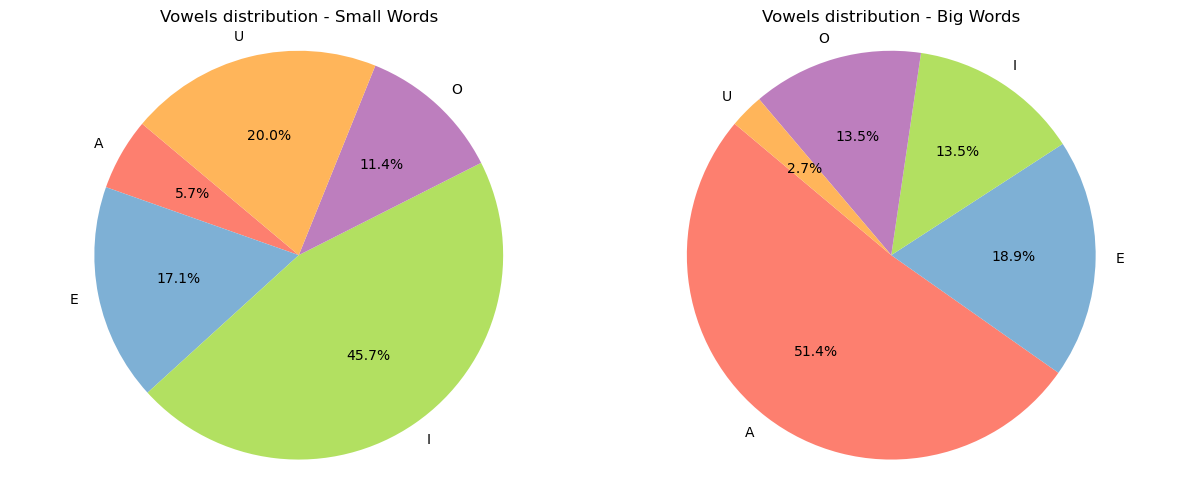

In [12]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
words_experiment_small.plot_vowels_distr(ax=axes[0], title="Vowels distribution - Small Words")
words_experiment_big.  plot_vowels_distr(ax=axes[1], title="Vowels distribution - Big Words"  )

plt.tight_layout()
plt.show()

The average length does not reveal interesting features.

In [13]:
print("Average length:")
print(f" - Small words: {words_experiment_small.avg_length}")
print(f" - Big   words: {words_experiment_big  .avg_length}")

Average length:
 - Small words: 5.125
 - Big   words: 5.625


### Subjects

We proceed by incorporating subject information into our analysis. Each set of responses provided by an individual subject will be treated as an experiment.

In [14]:
from model import Subject, Experiments

experiments = Experiments(words=words_experiment)

subject_ids = data.loc[:, "sbj_id"].unique().tolist()

for subject_id in subject_ids:
    
    # Create new subject
    new_subject = Subject(id_=subject_id)
    
    # Add answers
    for row in data[data.loc[:, "sbj_id"] == subject_id].itertuples(index=False):
        
        new_subject.add_answer(
            word_id=row.word_id,
            answer=Meaning.from_string(s=row.response)
        )
    
    experiments.add_subject(subject=new_subject)

In [15]:
experiments

Experiment[Subjects: 22 - Mean score: 0.646]

Initially, we examine the proportion of responses indicating small versus large objects given by each subject. The distribution of responses appears to be fairly balanced for each subject. Hence, we can infer that they had a bias on balanced proportion of small and big words in the experimental set.

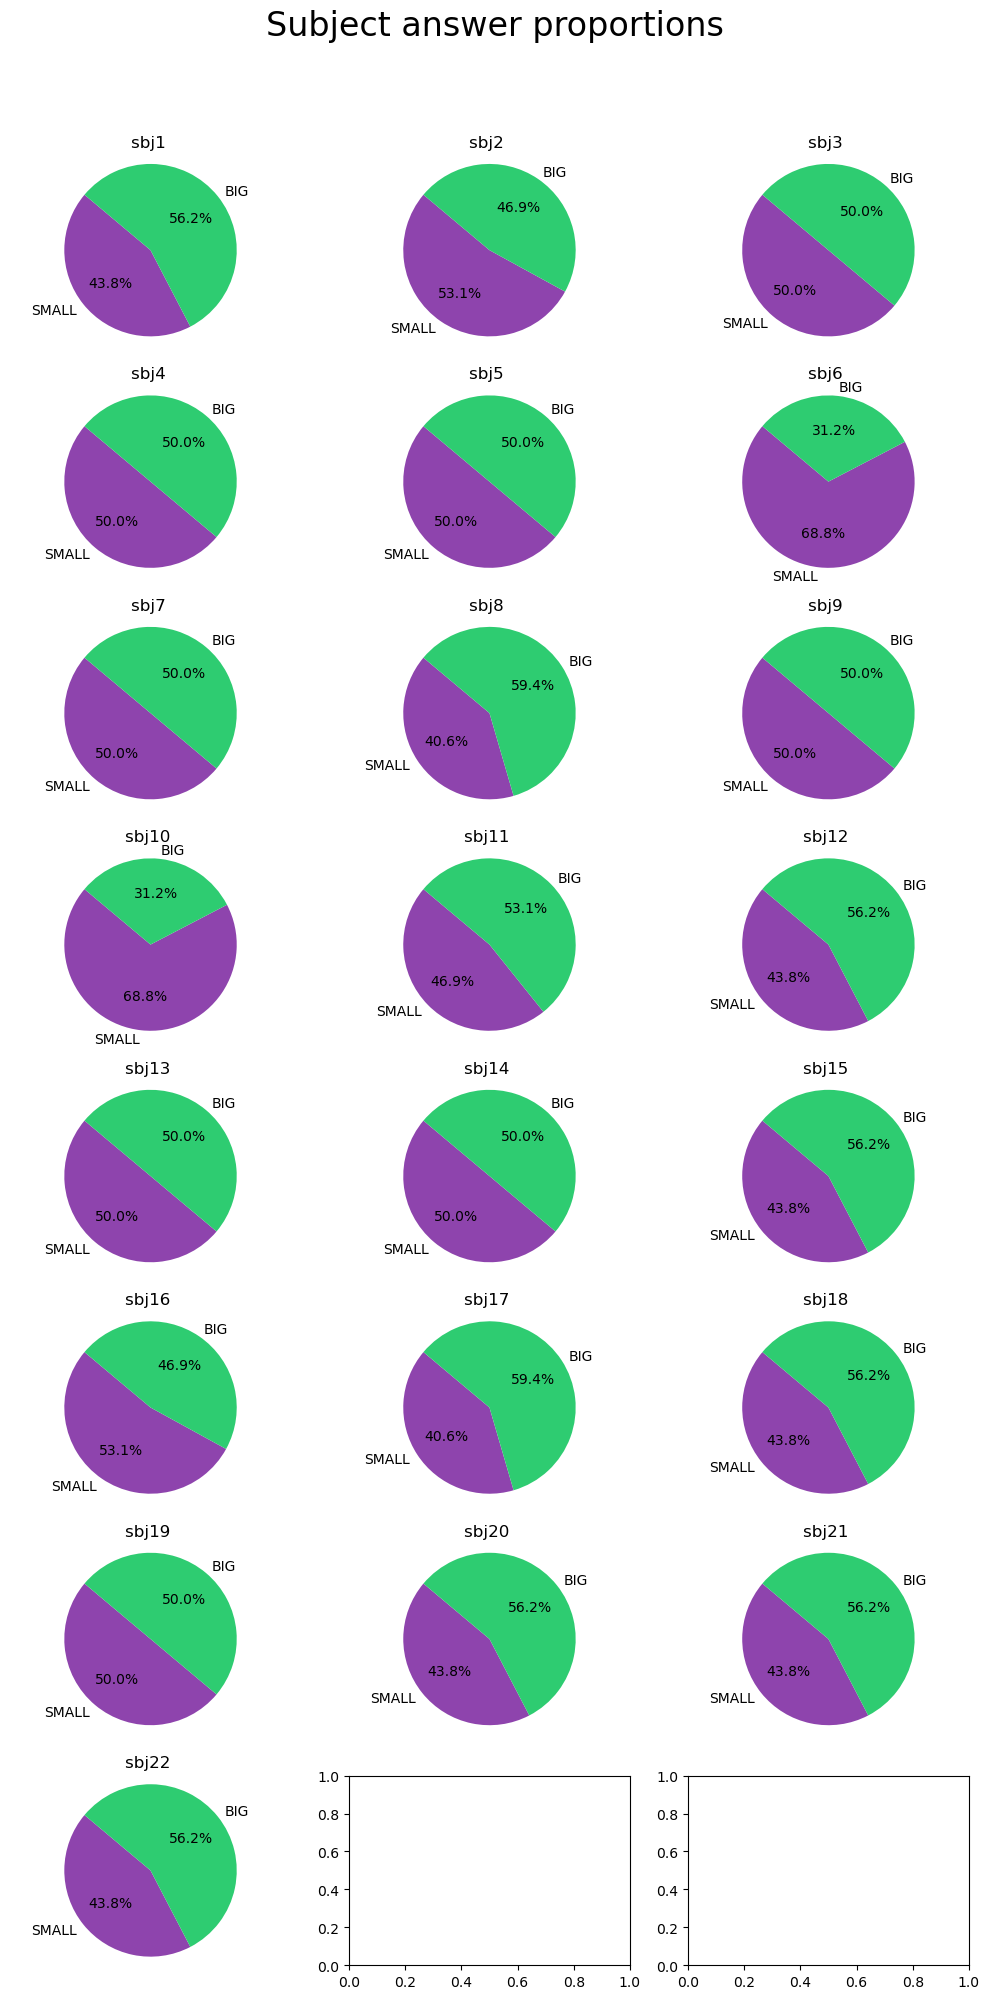

In [16]:
import matplotlib.pyplot as plt

N_COL = 3
N_ROW = 8

fig, axes = plt.subplots(N_ROW, N_COL, figsize=(10, 21))

for i in range(N_COL * N_ROW):
    
    if i >= len(experiments):
        break
        
    row = i // N_COL
    col = i % N_COL
    
    experiments[subject_ids[i]].subject.plot_answer_count(ax=axes[row, col], title="")
    
# Add a main title
fig.suptitle("Subject answer proportions", fontsize=24)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Subject Scores

Now, let's assess the subjects' responses based on the true meaning of the word and compute the percentage of correct answers.

The vast majority of participants demonstrate performance above chance level, with one particular subject performing exceptionally well at 80% accuracy, and two others achieving over 70% accuracy. However, two subjects fall slightly below chance level scoring 44% accuracy. On average, performance across all subjects is 15% above chance level.

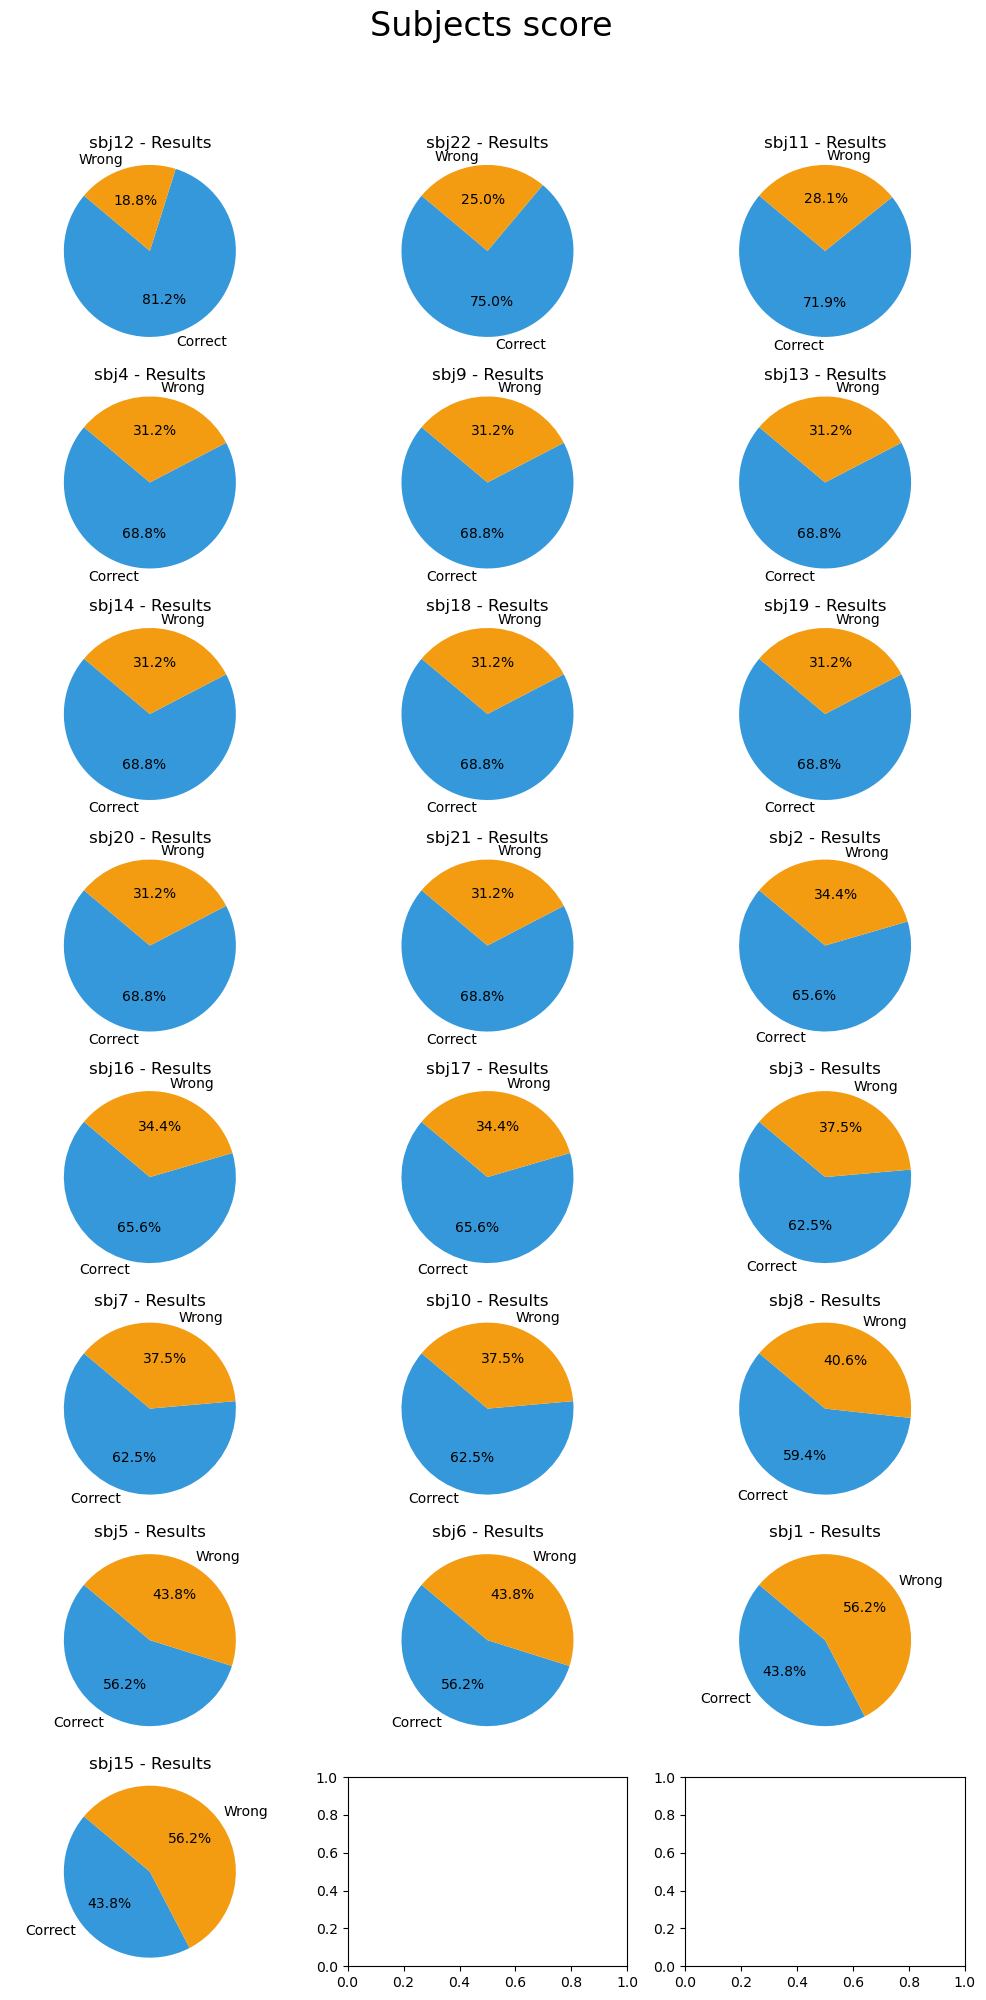

In [17]:
experiments.plot_subjects_scores(n_row=8, by_score=True)

In [18]:
print(f"Mean score: {round(experiments.mean_score, 3)}")

Mean score: 0.646


The subject with the highest score attained an exceptional result of 81%, significantly surpassing the average, whereas the one with the lowest score falls only slightly below the baseline with 44%.

In [19]:
_, best  = experiments.sort_by_score()[0]
_, worst = experiments.sort_by_score()[-1]

print(f"Best  subject: {best} ")
print(f"Worst subject: {worst}")

Best  subject: Experiment sbj12[Score: 0.8125] 
Worst subject: Experiment sbj15[Score: 0.4375]


Let's examine the confusion matrices of the two subjects.

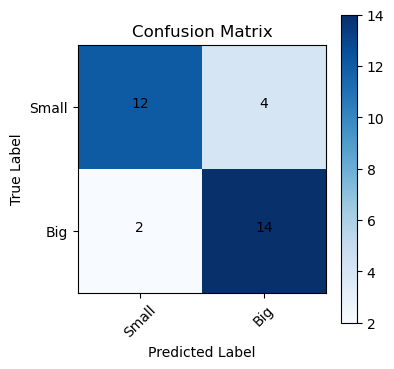

In [20]:
best.plot_confusion_matrix()

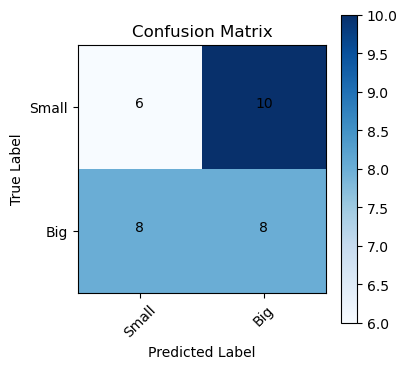

In [21]:
worst.plot_confusion_matrix()

Let's also take a look to the words the best subject got wrong.

In [22]:
for word in best.words_wrong:
    print(f"{word.word:>8} {'('+word.language+')':>12} - {word.meaning}")

   vogel   (albanian) - small
    gede (indonesian) - big
  vocerr   (albanian) - small
    tobi     (yoruba) - big
hen xiao   (mandarin) - small
     wei   (mandarin) - small


And the words the worst subject got correct.

In [23]:
for word in worst.words_correct:
    print(f"{word.word:>11} {'('+word.language+')':>12} - {word.meaning}")

      vogel   (albanian) - small
    raksasa (indonesian) - big
      besar (indonesian) - big
         xi   (mandarin) - small
    pang da   (mandarin) - big
     ghanda   (gujarati) - big
       kort      (dutch) - small
      vigan   (albanian) - big
      kutti      (tamil) - small
        wei   (mandarin) - small
    niraiya      (tamil) - big
ko de ha da     (korean) - big
     tintin     (yoruba) - small
 koskocaman    (turkish) - big


No clear pattern emerges.

### Vowel subject

Let's attempt to apply the strategy to look at vowels count by creating a subject who responds with "small" when the vowel I predominates and answers "big" predominantly for the vowel A.

In [24]:
from model import Experiment

vowel_subject = Subject(id_="vowel")

for word in words_experiment:
    
    n_a = word.vowels_count['a']
    n_i = word.vowels_count['i']
    
    answer = Meaning.SMALL if n_i > n_a else Meaning.BIG
    
    vowel_subject.add_answer(word_id=word.id_, answer=answer)

vowel_experiment = Experiment(subject=vowel_subject, words=words_experiment)

The score of this subject corresponds to guessing 3 words out of 4, and it performs better than the average of the subjects. Specifically, it performs worse than subject 22 and the same of subject 12, but it behaves better than all the others.

In [25]:
print(f"Vowel subject score: {vowel_experiment.score}")

Vowel subject score: 0.75


### Word answers

We're now interested in the responses to the words and their distribution between the two classes (without considering the true label for now).

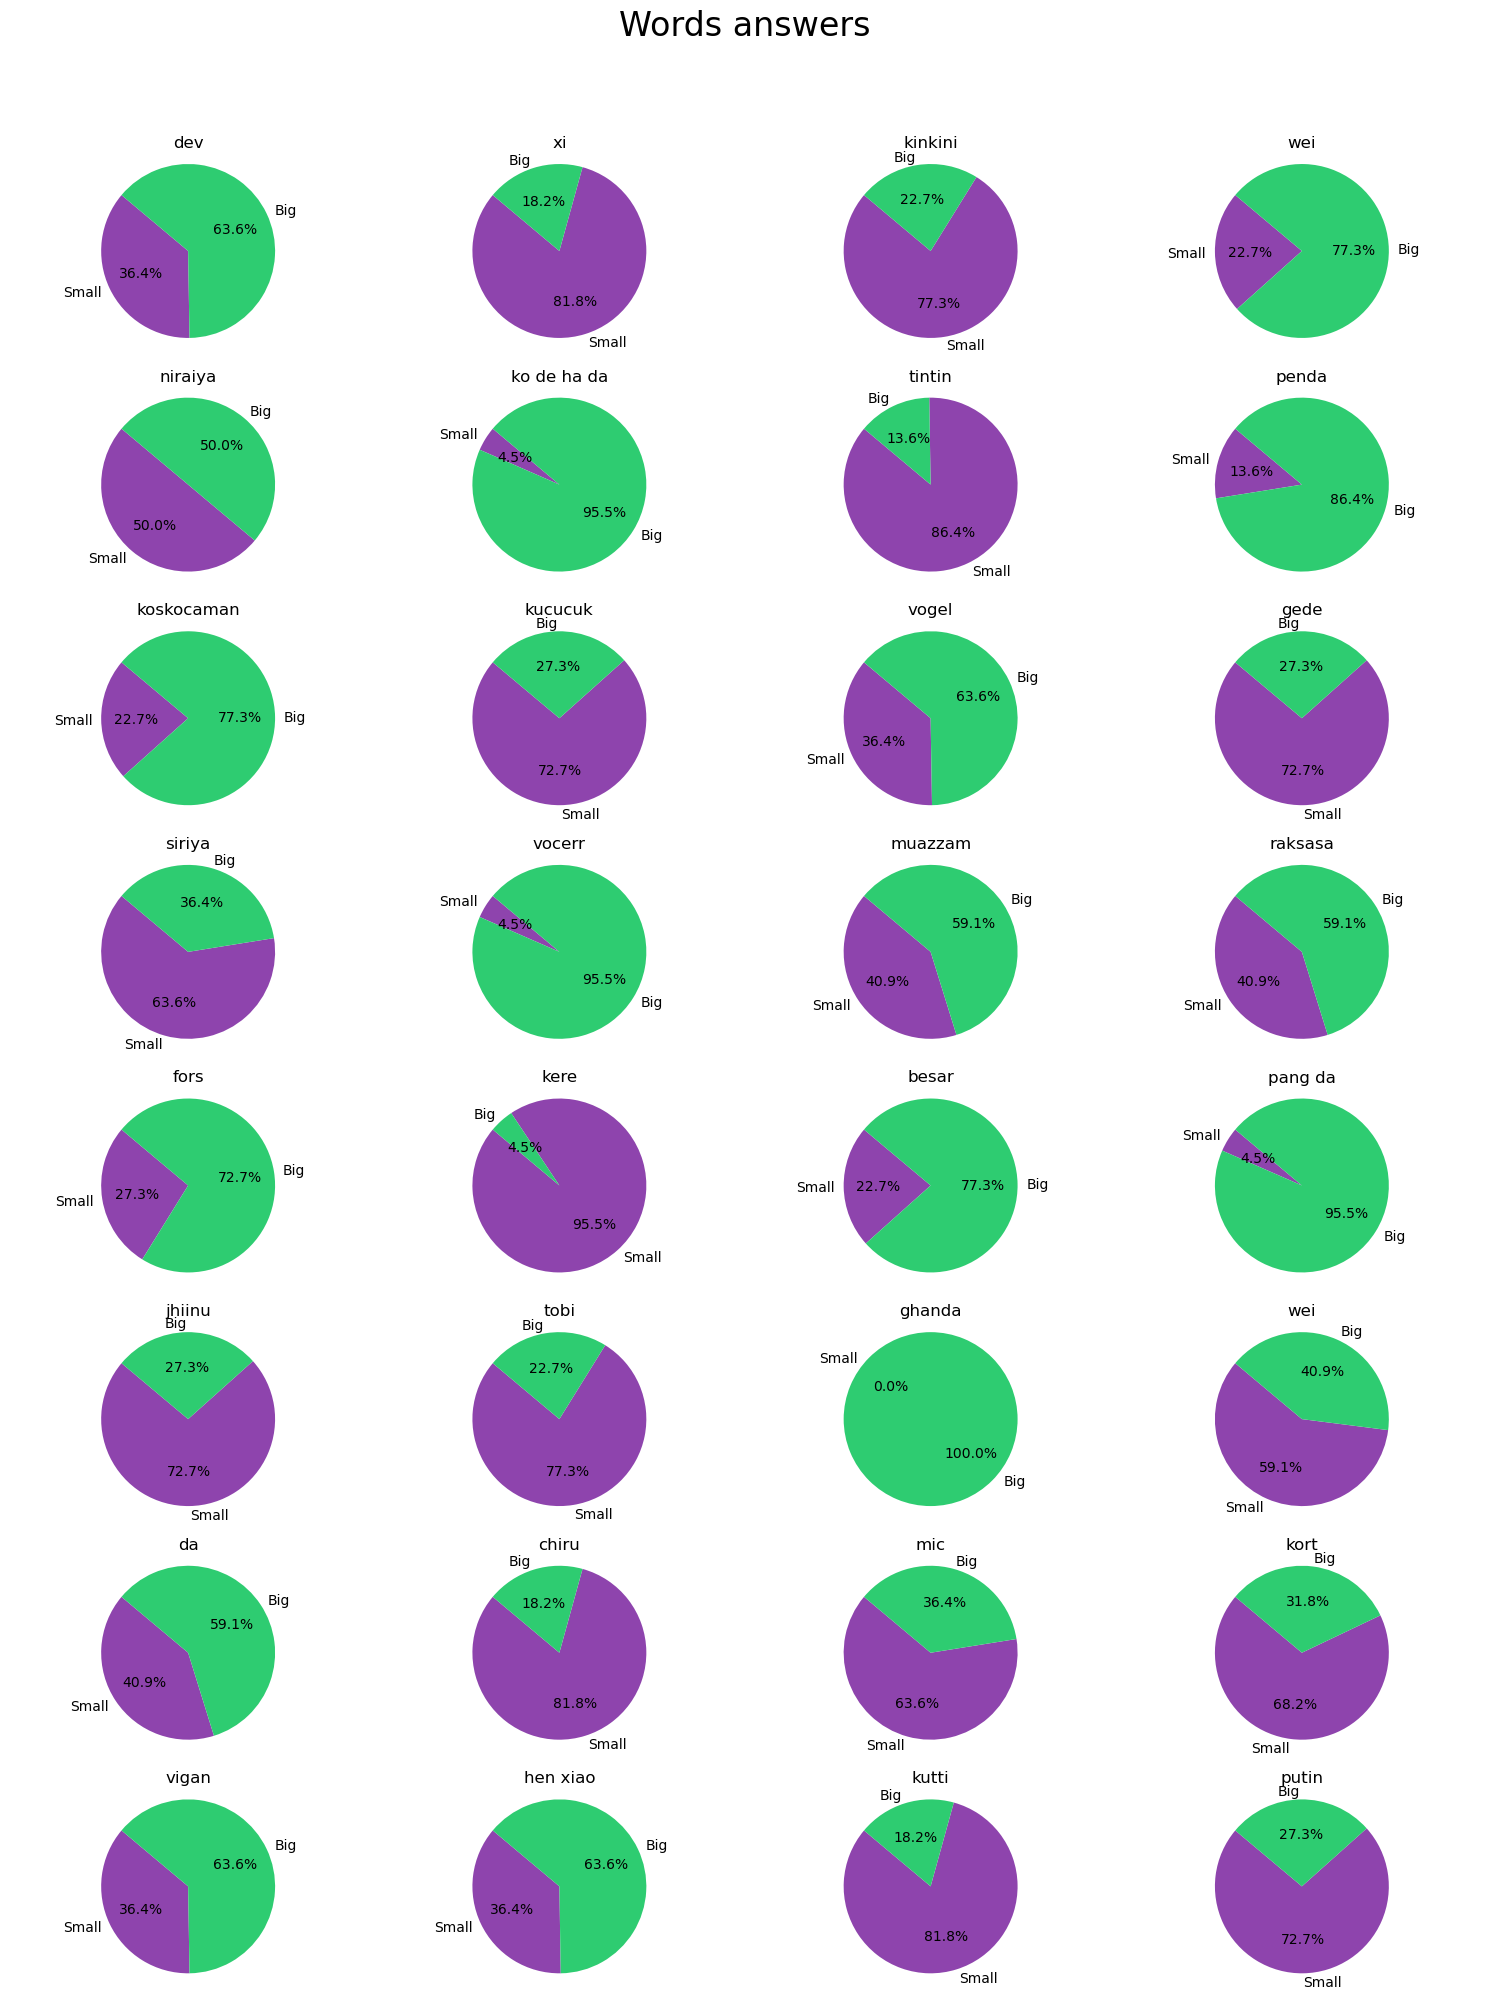

In [26]:
experiments.plot_words_answers(n_row=8)

The result exhibits high variability in the response proportion, prompting an analysis of the level of response proportionality using five different bins based on the degree of imbalance. Bins with an imbalance greater than 70-30 are more prevalent, indicating that subjects might have a common pattern that inclines their responses toward one of the two classes.

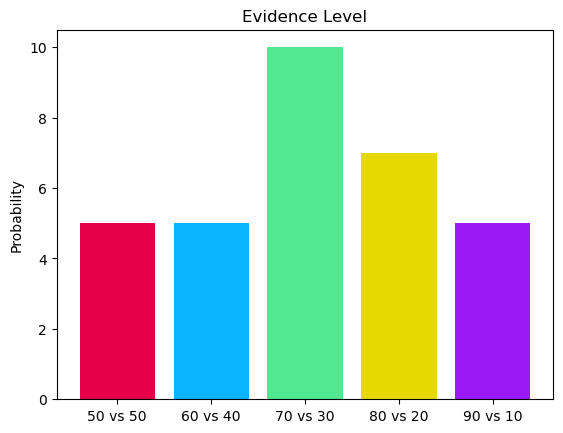

In [27]:
experiments.plot_evidence()


We'll examine words that result in 50-50 as well as those leading to a strong imbalance 90-10.

In [28]:
print("No evidence")

for word in experiments.get_evidence()["None"]:
    print(f" - {word.word:>11} {'('+word.language+')':<12} - {str(word.meaning).capitalize():>5}")
  
print()  
print("Strong evidence")

for word in experiments.get_evidence()["Strong"]:
    print(f" - {word.word:>11} {'('+word.language+')':<12} - {str(word.meaning).capitalize():>5}")

No evidence
 -     niraiya (tamil)      -   Big
 -     muazzam (turkish)    -   Big
 -     raksasa (indonesian) -   Big
 -         wei (mandarin)   -   Big
 -          da (mandarin)   -   Big

Strong evidence
 - ko de ha da (korean)     -   Big
 -      vocerr (albanian)   - Small
 -        kere (yoruba)     - Small
 -     pang da (mandarin)   -   Big
 -      ghanda (gujarati)   -   Big


All words with a 50-50 proportion refer to big objects, but no further patterns can be discerned.

### Word scores

We now analyze words' responses in relation to the true classes. The distribution covers almost all cases, ranging from perfect guesses to situations where almost everybody is incorrect, along with scenarios where responses are evenly split between the two options, or again tendencies towards favoring one of the two meanings.

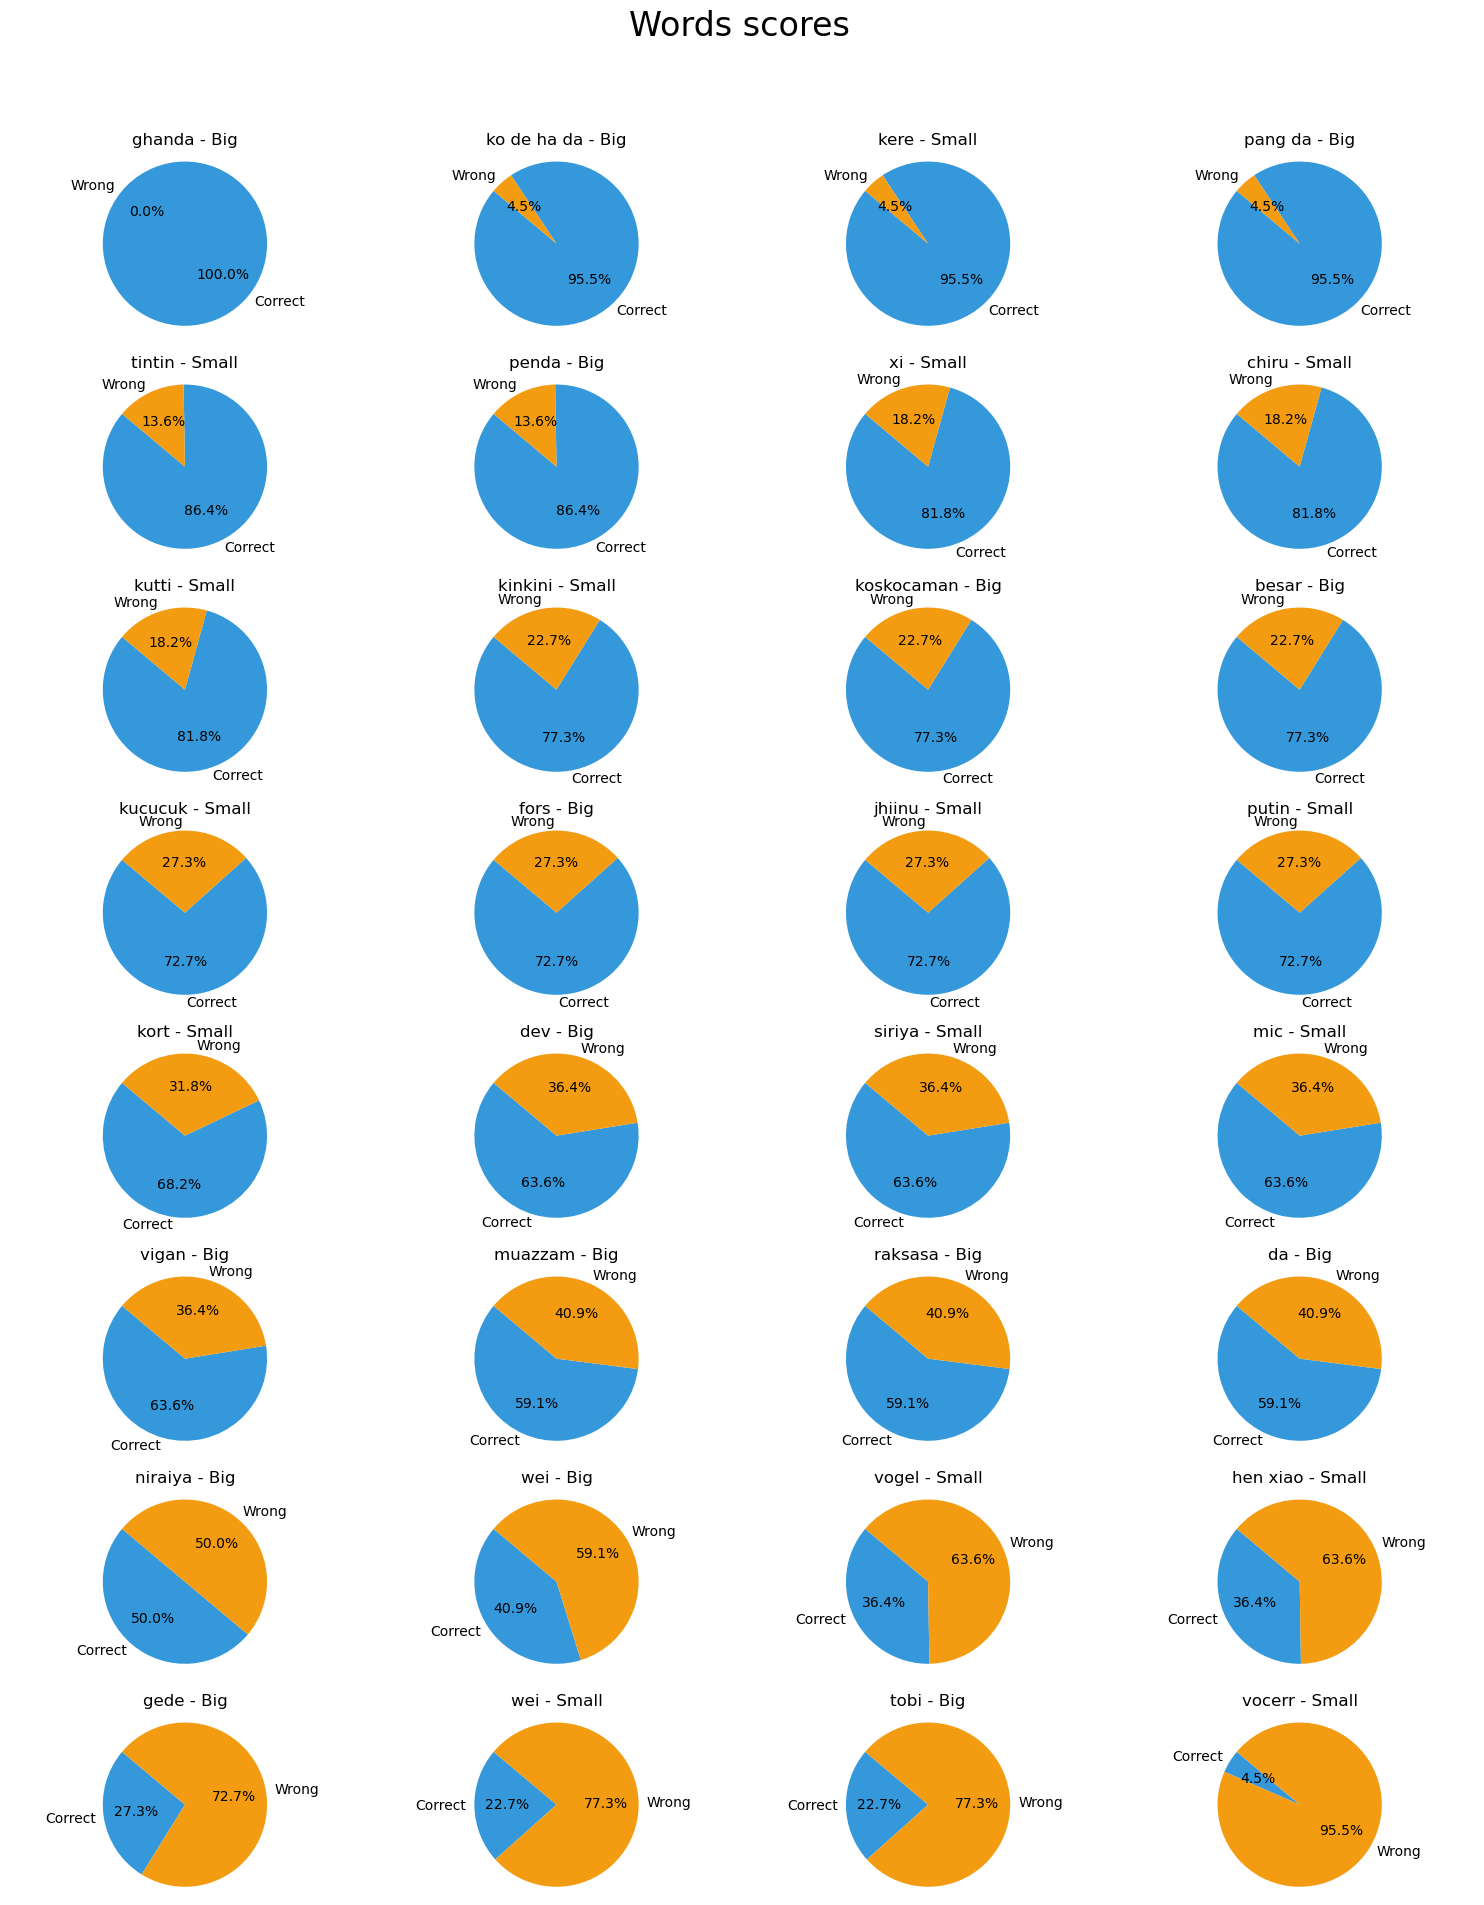

In [29]:
experiments.plot_words_scores(n_row=8, sort=True)

Let's also consider whether the word's language has an impact on its percieved meaning.

In [30]:
word_scores = experiments.get_words_results(sort=True)

for word_id, correct in word_scores:
    word = words_experiment[word_id]
    print(f" - {word.word:>11} {'('+word.language+')':<12} - {str(word.meaning).capitalize():>5}: [{correct:>2}]/[{len(experiments)}]")

 -      ghanda (gujarati)   -   Big: [22]/[22]
 - ko de ha da (korean)     -   Big: [21]/[22]
 -        kere (yoruba)     - Small: [21]/[22]
 -     pang da (mandarin)   -   Big: [21]/[22]
 -      tintin (yoruba)     - Small: [19]/[22]
 -       penda (gujarati)   -   Big: [19]/[22]
 -          xi (mandarin)   - Small: [18]/[22]
 -       chiru (tamil)      - Small: [18]/[22]
 -       kutti (tamil)      - Small: [18]/[22]
 -     kinkini (yoruba)     - Small: [17]/[22]
 -  koskocaman (turkish)    -   Big: [17]/[22]
 -       besar (indonesian) -   Big: [17]/[22]
 -     kucucuk (turkish)    - Small: [16]/[22]
 -        fors (dutch)      -   Big: [16]/[22]
 -      jhiinu (gujarati)   - Small: [16]/[22]
 -       putin (romanian)   - Small: [16]/[22]
 -        kort (dutch)      - Small: [15]/[22]
 -         dev (turkish)    -   Big: [14]/[22]
 -      siriya (tamil)      - Small: [14]/[22]
 -         mic (romanian)   - Small: [14]/[22]
 -       vigan (albanian)   -   Big: [14]/[22]
 -     muazza

Language doens't seem to have a effect.

### 3. Neural network

### Disclimer

The process of selecting and training the neural network deviates from the typical pipeline. There is no hyperparameter tuning, and there's no evaluation of a validation loss to stop the training process, potentially resulting in overfitting.

This approach is adopted because the primary goal is not to train a high-performing network, but rather to analyze how if this kind of architecture behaves on a task analogous to a human subjects.

### Training

The previous analyses suggest that subjects are capable of discerning a common pattern within words that may be correlated with their meaning. It can be hypothesized that this ability arises from exposure in everyday life to words representing the two classes. To simulate this phenomenon, let's train a neural network that, given a word as input, predicts the probability that it refers to a large or small object.

Since the majority of subjects are native Italian speakers proficient in English as well, let's utilize words from these two languages for training the neural network.

Words are listed in `small.txt` and `big.txt`.

In [31]:
from io_ import TXTLoader
from settings import SMALL_WORDS_FILE, BIG_WORDS_FILE

small_words_tokens = TXTLoader(file_path=SMALL_WORDS_FILE).load()
big_words_tokens   = TXTLoader(file_path=  BIG_WORDS_FILE).load()

Let's see some example.

In [32]:
import random

print("Small words")
for small_word in random.sample(small_words_tokens, 10):
    print(f"- {small_word}")
    
print()
print("Big words")
for big_word in random.sample(big_words_tokens, 10):
    print(f"- {big_word}")


Small words
- candy
- tappo
- centrino
- seme
- sock
- ring
- pearl
- pallottola
- gum
- fiammifero

Big words
- piazza
- aereo
- armadio
- cattedrale
- sottomarino
- collina
- stazione
- tower
- campo
- satellite


The word set is not as evenly balanced as the experimental one, with one hundred words more in the set of big ones.

In [33]:
words_training = Words()

for i, small_word in enumerate(small_words_tokens, start=1):
    
    new_word = Word(
        id_=f"sw{i}",
        word=small_word,
        language="it/eng", 
        meaning=Meaning.from_string('small'),
        is_sound_symbolic=False
    )
    
    words_training.add_word(word=new_word)
    
for i, big_word in enumerate(big_words_tokens, start=1):
    
    new_word = Word(
        id_=f"bw{i}",
        word=big_word,
        language="it/eng", 
        meaning=Meaning.from_string('big'),
        is_sound_symbolic=False
    )
    
    words_training.add_word(word=new_word)

In [34]:
words_training

Words[count: 725, small: 311, big: 414]

There is no clear distinction in the distribution of vowels as observed in the experimental set.

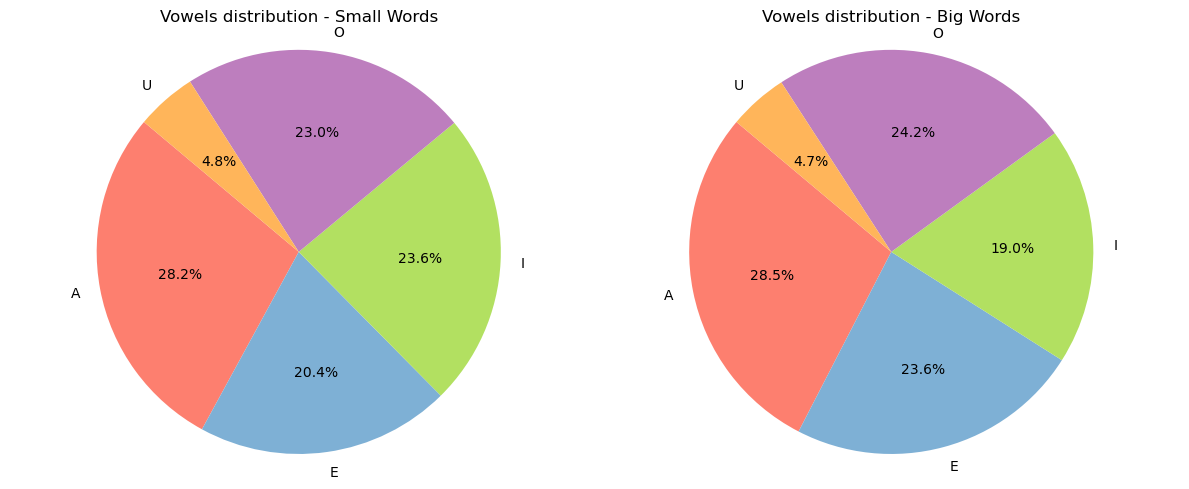

In [35]:
words_training_small, words_training_big = words_training.get_meaning_split()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
words_training_small.plot_vowels_distr(ax=axes[0], title="Vowels distribution - Small Words")
words_training_big.  plot_vowels_distr(ax=axes[1], title="Vowels distribution - Big Words"  )

plt.tight_layout()
plt.show()

We will employ a type of recurrent neural network (RNN) that operates at the character level. This neural network is beneficial for capturing interdependencies and rules in word construction.


In [36]:
from network import Alphabet

alphabet = Alphabet()

for word in words_training:
    alphabet.add_word(word=word.word)
    
alphabet

Alphabet[size: 31]


The network has one hyperparameter, the hidden size, which we set to 50.

In [37]:
from network import MeaningClassifier

HIDDEN_SIZE = 50

model = MeaningClassifier(
    alphabet=alphabet,
    hidden_size=HIDDEN_SIZE,
)

model

MeaningClassifier(
  (input_to_hidden): Embedding(31, 25)
  (hidden_to_hidden): Linear(in_features=50, out_features=25, bias=True)
  (hidden_to_output): Linear(in_features=50, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

We establish training configurations.

In [38]:
from settings import DEVICE
from network import ModelConfig

config = ModelConfig(
    epochs=10000,
    epochs_log=150,
    lr=0.001,   
    device=DEVICE
)

config

ModelConfig[epochs: 10000; epochs-log: 150; lr: 0.001; device: cpu]

Let's train the network for a predetermined number of epochs.

In [39]:
from network import Trainer

trainer = Trainer(
    words=words_training,
    model=model,
    config=config
)

In [40]:
%time
inference = trainer.train()

CPU times: total: 0 ns
Wall time: 0 ns
Epoch: 150 (1.5%)
  Loss:        0.5084282755851746
  Word:        abitazione
  Meaning:     big
  Prob. Small: 0.3985598087310791
  Prob. Big:   0.6014401316642761
Epoch: 300 (3.0%)
  Loss:        0.65712970495224
  Word:        newsstand
  Meaning:     big
  Prob. Small: 0.4816630482673645
  Prob. Big:   0.5183369517326355
Epoch: 450 (4.5%)
  Loss:        0.5632563829421997
  Word:        constellation
  Meaning:     big
  Prob. Small: 0.43064793944358826
  Prob. Big:   0.5693519711494446
Epoch: 600 (6.0%)
  Loss:        1.0305925607681274
  Word:        dwelling
  Meaning:     big
  Prob. Small: 0.6432045102119446
  Prob. Big:   0.3567954897880554
Epoch: 750 (7.5%)
  Loss:        0.45707404613494873
  Word:        avenue
  Meaning:     big
  Prob. Small: 0.3668665289878845
  Prob. Big:   0.6331334710121155
Epoch: 900 (9.0%)
  Loss:        0.6801755428314209
  Word:        supermercato
  Meaning:     big
  Prob. Small: 0.4934719204902649
  Prob.

### Model analysis

The training loss decreases initially but then stabilizes and begins to oscillate, indicating that a certain learning capacity has been achieved.

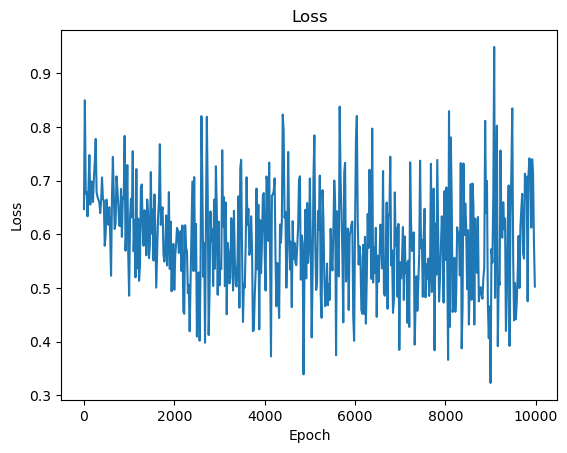

In [41]:
inference.plot_loss(title="Loss")

The confusion matrix appears satisfactory, but it may indicate overfitting. Therefore, we also evaluate the model on a test set that hasn't been seen during training to ensure a more comprehensive assessment.

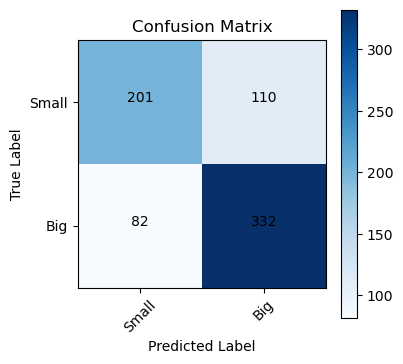

In [42]:
inference.plot_confusion_matrix(words=words_training)

Let's also evaluate predictions on a test set. The model is likely prone to predict the "big" class as it's biased towards the training set, which contains more big words.

In [43]:
from settings import SMALL_WORDS_FILE_TEST, BIG_WORDS_FILE_TEST

small_words_test_tokens = TXTLoader(file_path=SMALL_WORDS_FILE_TEST).load()
big_words_test_tokens   = TXTLoader(file_path=  BIG_WORDS_FILE_TEST).load()

words_test = Words()

for i, small_word in enumerate(small_words_test_tokens, start=1):
    
    new_word = Word(
        id_=f"sw{i}_test",
        word=small_word,
        language="it/eng", 
        meaning=Meaning.from_string('small'),
        is_sound_symbolic=False
    )
    
    words_test.add_word(word=new_word)
    
for i, big_word in enumerate(big_words_test_tokens, start=1):
    
    new_word = Word(
        id_=f"bw{i}_test",
        word=big_word,
        language="it/eng", 
        meaning=Meaning.from_string('big'),
        is_sound_symbolic=False
    )
    
    words_test.add_word(word=new_word)

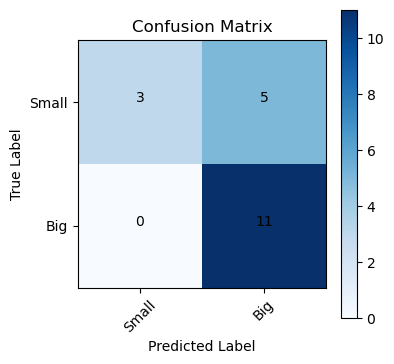

In [44]:
inference.plot_confusion_matrix(words=words_test)

Finally, we visualize word embeddings in a 2-dimensional space using TSNE dimensionality reduction. TSNE is expected to preserve clusters of points when projecting to a lower dimension, but no clear pattern emerges.

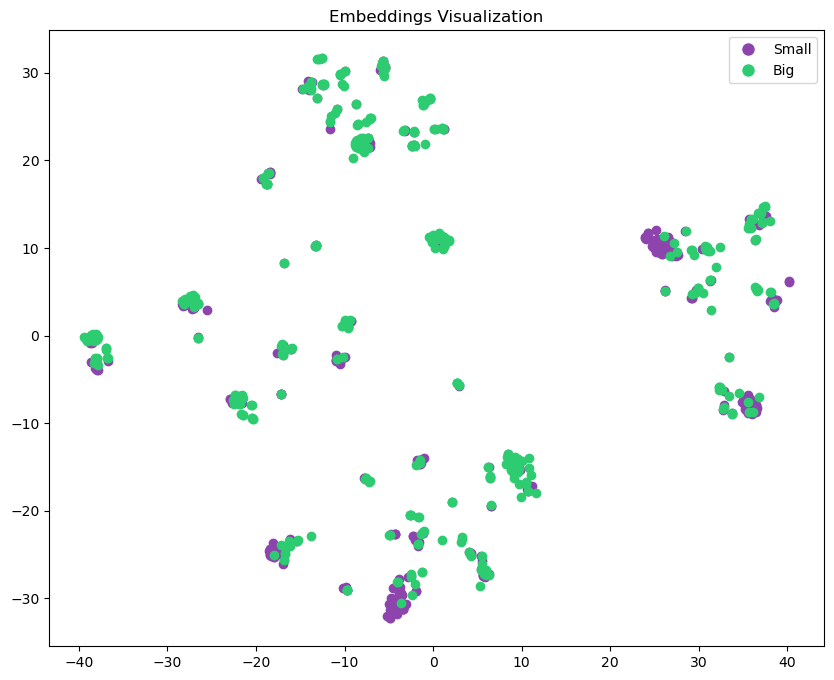

In [45]:
inference.plot_embedding(words=words_training)

### Comparison with Human assessment

For each word, let's compare pie charts between the neural network and human subjects. It's important to remember that the two have entirely different interpretations. The proportions in the human experiment come from an averaging across multiple subjects, while the neural network directly returns the probability distribution for each class using softmax.

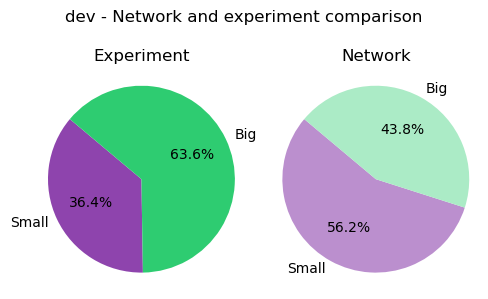

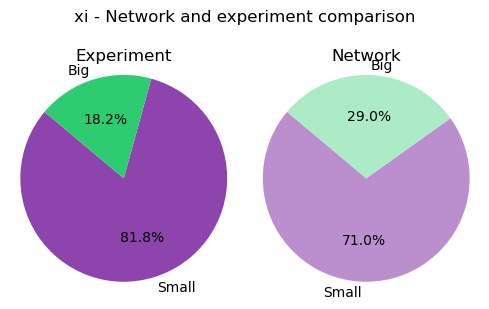

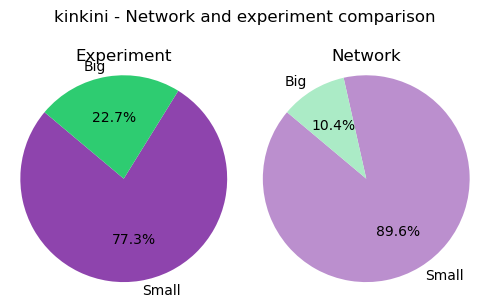

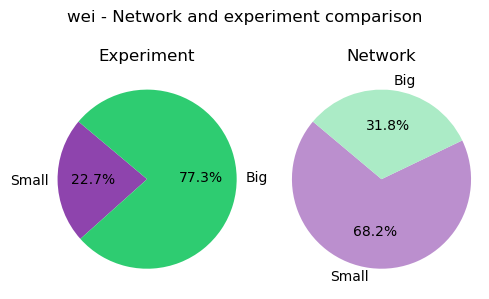

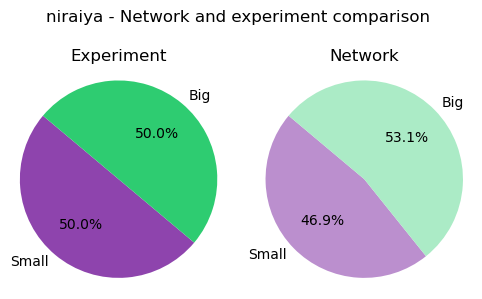

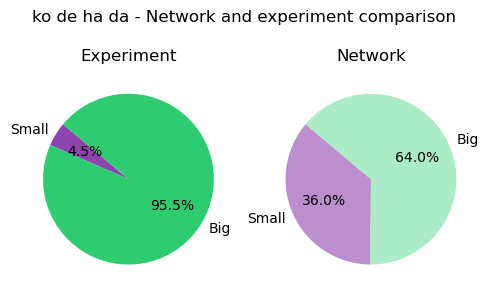

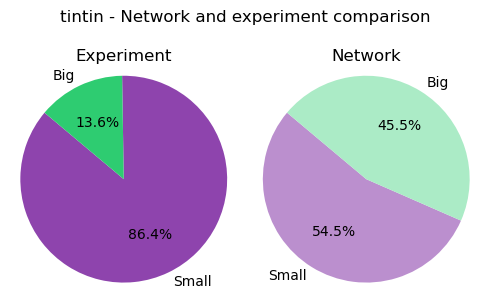

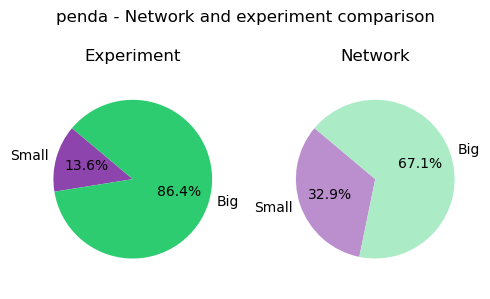

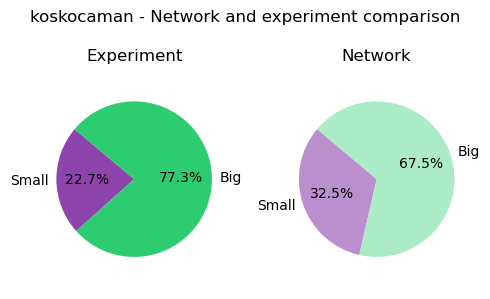

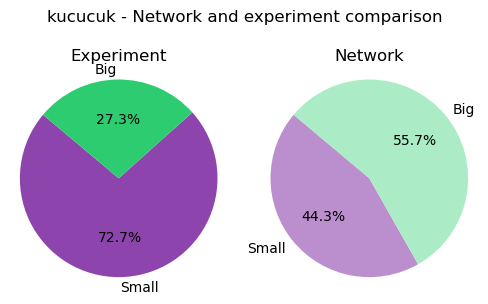

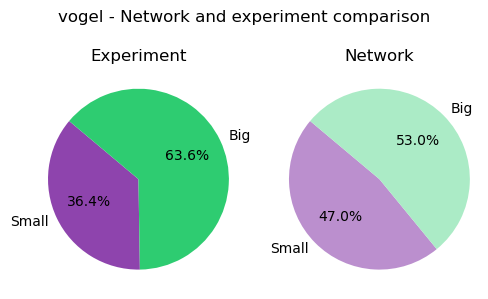

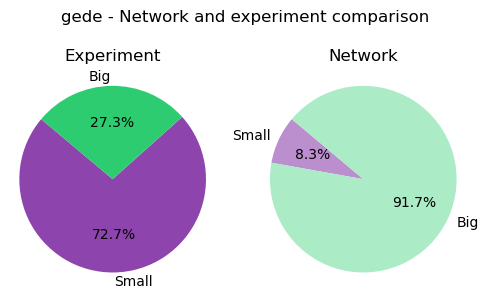

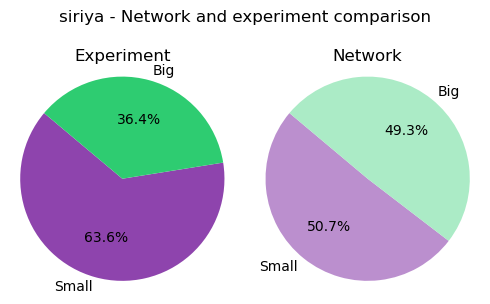

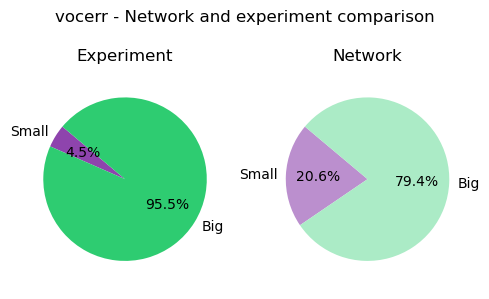

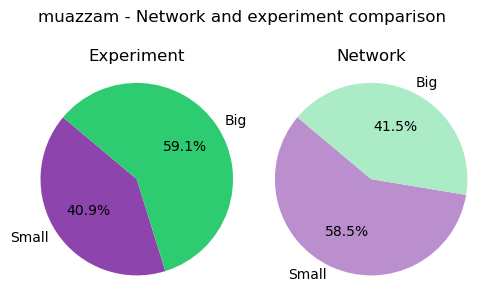

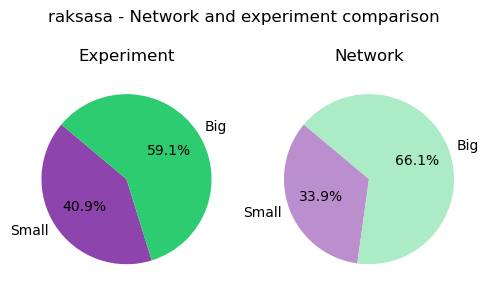

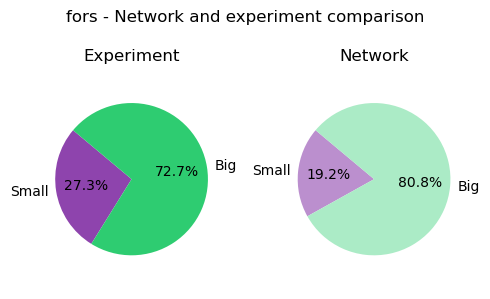

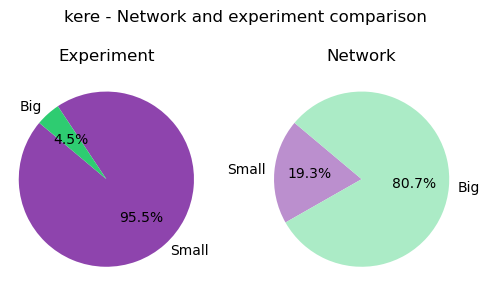

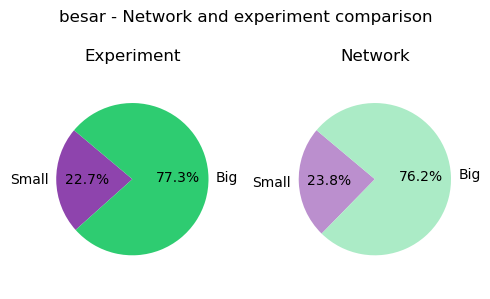

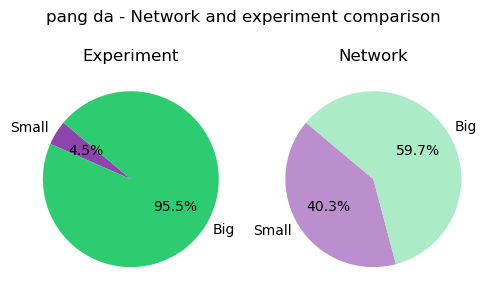

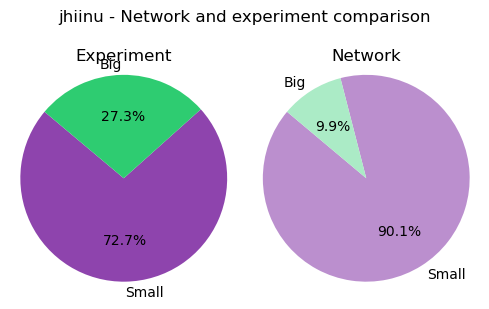

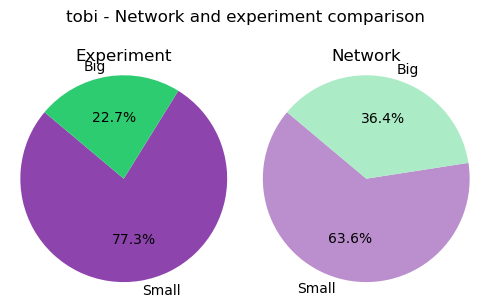

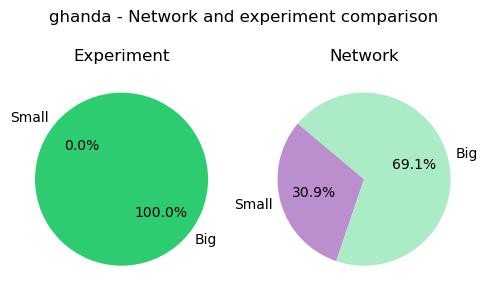

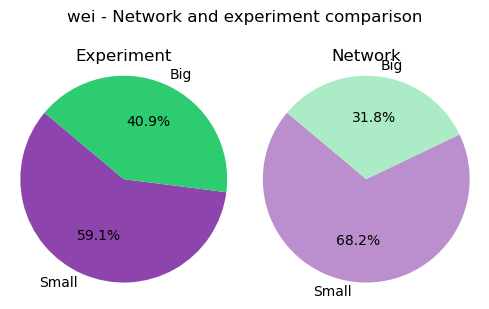

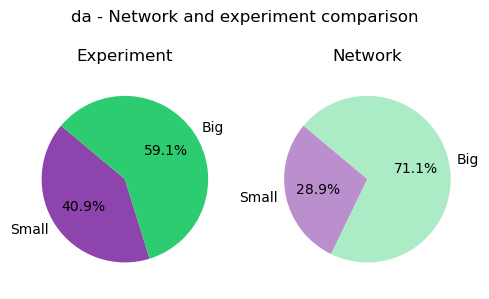

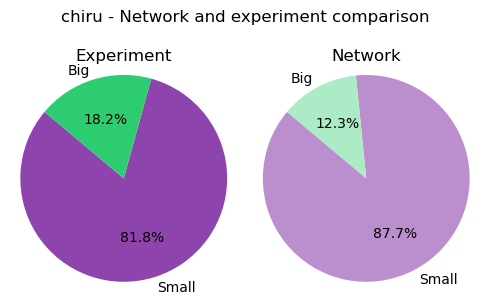

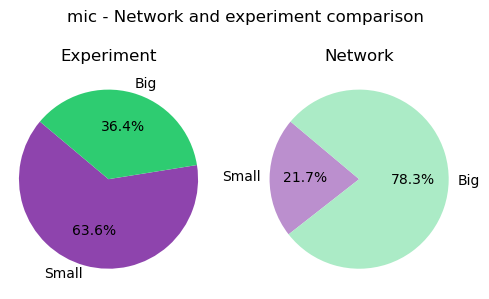

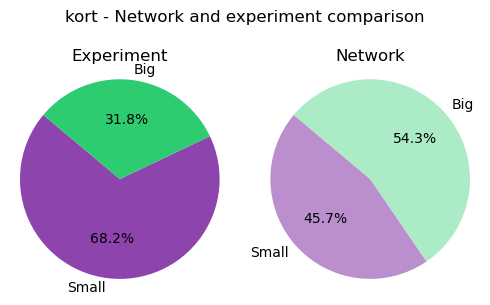

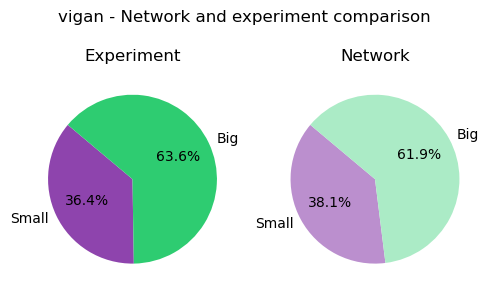

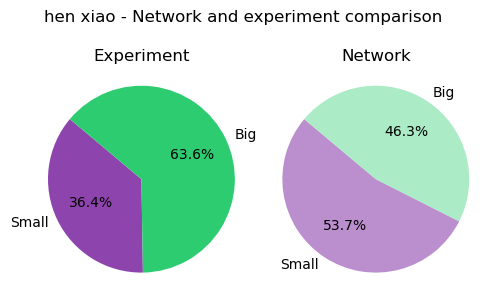

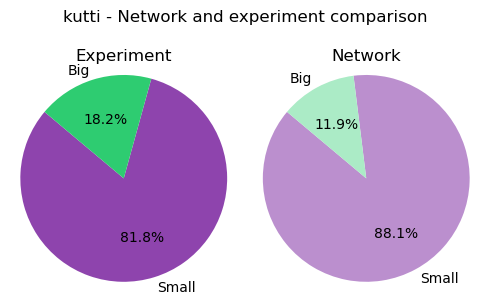

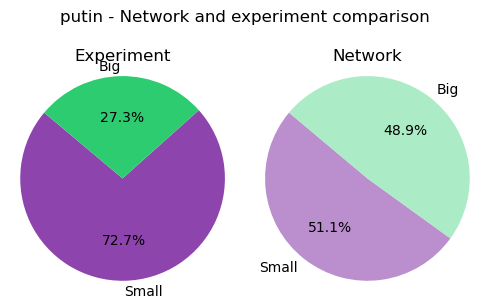

In [46]:
from settings import SMALL_BIG_COLORS, NETWORK_COLORS
from io_ import pie_plot

for word_id, answer in experiments.get_word_answers().items():
    
    word = words_experiment[word_id]
    
    experiment_probs = [count / sum(answer) for count in answer]
    network_probs = inference.predict(word=word.word)
    
    labels = ["Small", "Big"]
    
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))  
    pie_plot(labels=labels, sizes=experiment_probs, colors=SMALL_BIG_COLORS, title="Experiment", ax=axes[0])
    pie_plot(labels=labels, sizes=network_probs,    colors=NETWORK_COLORS, title="Network", ax=axes[1])
    
    fig.suptitle(f"{word.word} - Network and experiment comparison")
    fig.tight_layout()
    plt.show()
    

In certain cases, there is a good matching between the predictions of the neural network and the responses of human subjects. However, this alignment occurs infrequently.

Finally, let's assess the score of the network when it predicts the most probable class. The accuracy score surpasses the average of human subjects, reaching 69%, which is nearly 20% above chance level. This suggests that the network has managed to capture some meaningful word intra-dependencies to determine the meaning of the word, even in a language entirely different from that encountered during training.

In [47]:
import numpy as np

rnn_subject = Subject(id_="rnn")

for word in words_experiment:
    
    network_probs = inference.predict(word=word.word)
    pred = np.argmax(network_probs)
    
    answer = Meaning.SMALL if pred == 0 else Meaning.BIG
    
    rnn_subject.add_answer(word_id=word.id_, answer=answer)

rnn_experiment = Experiment(subject=rnn_subject, words=words_experiment)

In [49]:
print("Accuracies")
print(f"- experiment: {experiments.mean_score}")
print(f"- network:    {rnn_experiment.score}")

Accuracies
- experiment: 0.6463068181818182
- network:    0.6875


Let's see network confusion matrix, which appears unbiased.

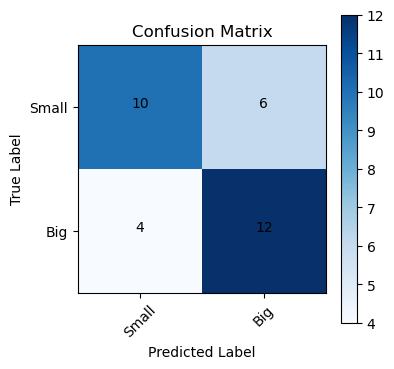

In [48]:
rnn_experiment.plot_confusion_matrix()

### 4. Conclusion

Both the experiment and the neural network are toy examples that cannot be considered as significant for drawing conclusions; a more formal experimental setup, network modeling, and training dataset would be required. Despite their limitations, these preliminary results hint at the intriguing possibility that there could be deeper semantic connections embedded within the seemingly arbitrary nature of words. While further research is needed to validate and explore this hypothesis, these initial findings suggest strategies for future inquiry into the complexities of language and meaning.